In [2]:
# Programming Exercise 2: Handwriting Recognition with TensorFlow LeNet
# Implementation based on Chapter 4: Convolutional Neural Networks

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import seaborn as sns

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print(f"TensorFlow version: {tf.__version__}")


TensorFlow version: 2.18.0


In [11]:
# ===================================================================
# 1. DEFINE THE LENET NETWORK
# ===================================================================

def create_lenet_model():
    """
    Define the LeNet-5 architecture as described in Chapter 4.
    LeNet is one of the first successful CNNs for digit recognition.

    Architecture:
    - Input: 32x32x1 (grayscale images)
    - Conv2D: 6 filters, 5x5 kernel, tanh activation
    - AveragePooling2D: 2x2
    - Conv2D: 16 filters, 5x5 kernel, tanh activation
    - AveragePooling2D: 2x2
    - Flatten
    - Dense: 120 units, tanh activation
    - Dense: 84 units, tanh activation
    - Dense: 10 units, softmax activation (for 10 digit classes)
    """

    model = models.Sequential([
        # Resize MNIST 28x28 to 32x32 to match LeNet input
        layers.Lambda(lambda x: tf.image.resize(x, [32, 32])),

        # First Convolutional Layer
        layers.Conv2D(6, kernel_size=(5, 5), activation='tanh',
                     input_shape=(32, 32, 1), name='conv2d_1'),
        layers.AveragePooling2D(pool_size=(2, 2), name='avgpool2d_1'),

        # Second Convolutional Layer
        layers.Conv2D(16, kernel_size=(5, 5), activation='tanh', name='conv2d_2'),
        layers.AveragePooling2D(pool_size=(2, 2), name='avgpool2d_2'),

        # Flatten and Fully Connected Layers
        layers.Flatten(name='flatten'),
        layers.Dense(120, activation='tanh', name='dense_1'),
        layers.Dense(84, activation='tanh', name='dense_2'),
        layers.Dense(10, activation='softmax', name='output')
    ])

    return model

# Create the LeNet model
lenet_model = create_lenet_model()

# Build the model by specifying input shape
lenet_model.build(input_shape=(None, 28, 28, 1))

# Display model architecture
print("LeNet-5 Model Architecture:")
print("=" * 50)
lenet_model.summary()

# Visualize model architecture (optional - skip if graphviz not available)
try:
    tf.keras.utils.plot_model(lenet_model, to_file='lenet_architecture.png',
                              show_shapes=True, show_layer_names=True)
    print("Model architecture diagram saved as 'lenet_architecture.png'")
except Exception as e:
    print(f"Could not create model diagram: {e}")
    print("(This is optional - the model will still work fine)")


LeNet-5 Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)               │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool2d_1 (AveragePooling2D)  │ (None, 14, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ avgpool2d_2 (AveragePooling2D)  │ (None, 5, 5, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,706 (241.04 KB)

 Trainable params: 61,706 (241.04 KB)

 Non-trainable params: 0 (0.00 B)

Model architecture diagram saved as 'lenet_architecture.png'


In [4]:
# ===================================================================
# 2. DATA PREPARATION
# ===================================================================

# Load MNIST dataset
print("\nLoading MNIST dataset...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Preprocess the data
# Normalize pixel values to [0, 1] range
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to add channel dimension (28, 28, 1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Convert labels to categorical one-hot encoding
y_train_categorical = keras.utils.to_categorical(y_train, 10)
y_test_categorical = keras.utils.to_categorical(y_test, 10)

print(f"\nAfter preprocessing:")
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train_categorical.shape}")



Loading MNIST dataset...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)

After preprocessing:
Training data shape: (60000, 28, 28, 1)
Training labels shape: (60000, 10)


In [5]:
# ===================================================================
# 3. TRAINING THE NETWORK
# ===================================================================

# Compile the model
lenet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel compiled successfully!")
print("Optimizer: Adam")
print("Loss function: Categorical Crossentropy")
print("Metrics: Accuracy")

# Define callbacks for better training monitoring
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
]



Model compiled successfully!
Optimizer: Adam
Loss function: Categorical Crossentropy
Metrics: Accuracy


In [6]:
# ===================================================================
# 4. EXECUTE THE MODEL FOR 20 EPOCHS
# ===================================================================

print("\n" + "="*60)
print("TRAINING THE LENET MODEL FOR 20 EPOCHS")
print("="*60)

# Train the model
history = lenet_model.fit(
    x_train, y_train_categorical,
    batch_size=128,
    epochs=20,
    validation_data=(x_test, y_test_categorical),
    callbacks=callbacks,
    verbose=1
)




TRAINING THE LENET MODEL FOR 20 EPOCHS
Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 86ms/step - accuracy: 0.8274 - loss: 0.5947 - val_accuracy: 0.9563 - val_loss: 0.1429 - learning_rate: 0.0010
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 30s 63ms/step - accuracy: 0.9599 - loss: 0.1352 - val_accuracy: 0.9701 - val_loss: 0.0929 - learning_rate: 0.0010
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 63ms/step - accuracy: 0.9751 - loss: 0.0841 - val_accuracy: 0.9735 - val_loss: 0.0775 - learning_rate: 0.0010
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms/step - accuracy: 0.9819 - loss: 0.0613 - val_accuracy: 0.9803 - val_loss: 0.0623 - learning_rate: 0.0010
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 36s 62ms/step - accuracy: 0.9865 - loss: 0.0467 - val_accuracy: 0.9812 - val_loss: 0.0559 - learning_rate: 0.0010
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9889 - loss: 0.0370 - val_accuracy: 0.9827 - val_loss: 0.0521 - learning_rate: 0.0010
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━

In [7]:
# ===================================================================
# 5. MODEL EVALUATION AND RESULTS
# ===================================================================

print("\n" + "="*60)
print("MODEL EVALUATION RESULTS")
print("="*60)

# Evaluate on test set
test_loss, test_accuracy = lenet_model.evaluate(x_test, y_test_categorical, verbose=0)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Final Test Loss: {test_loss:.4f}")

# Get predictions
predictions = lenet_model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)

# Generate classification report
print("\nDetailed Classification Report:")
print("-" * 50)
print(classification_report(y_test, predicted_classes))




MODEL EVALUATION RESULTS
Final Test Accuracy: 0.9873 (98.73%)
Final Test Loss: 0.0395
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Detailed Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.98      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



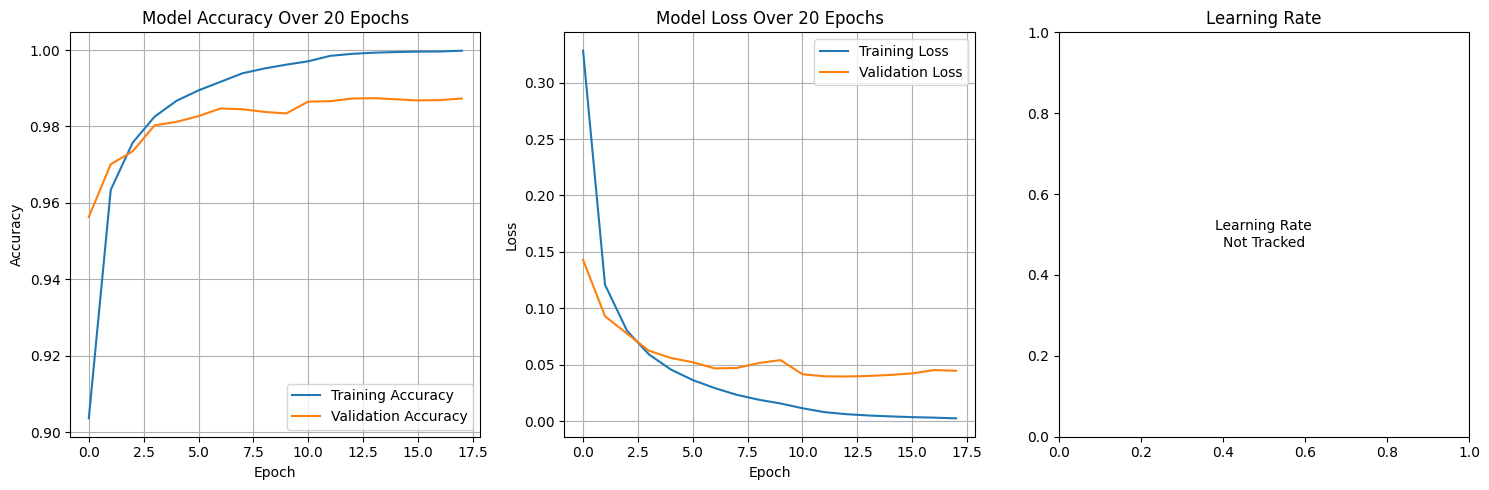

In [8]:
# ===================================================================
# 6. VISUALIZE TRAINING PROGRESS
# ===================================================================

plt.figure(figsize=(15, 5))

# Plot training & validation accuracy
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over 20 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot learning rate (if available)
plt.subplot(1, 3, 3)
if 'lr' in history.history:
    plt.plot(history.history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
else:
    plt.text(0.5, 0.5, 'Learning Rate\nNot Tracked',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Learning Rate')

plt.tight_layout()
plt.show()




ANALYZING MODEL PREDICTIONS ON SAMPLE IMAGES
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


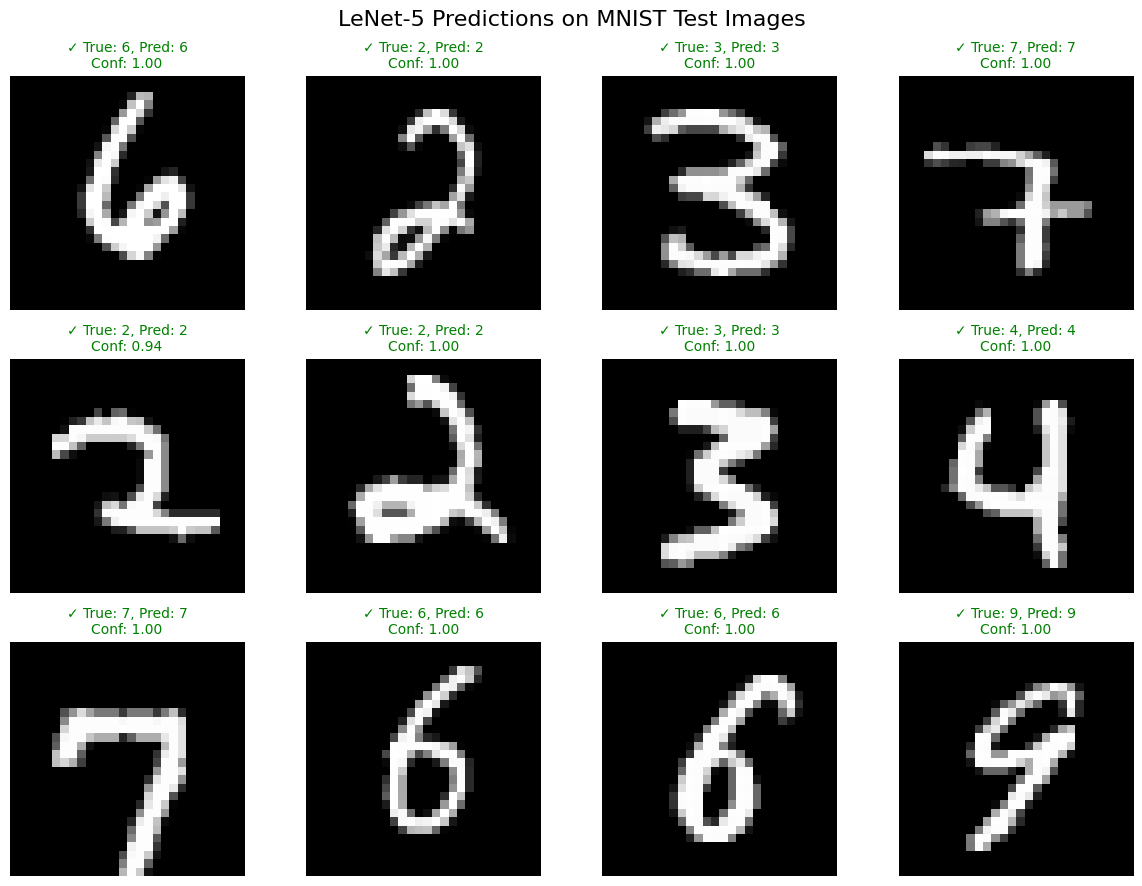

Accuracy on displayed sample: 1.000 (100.0%)


In [9]:
# ===================================================================
# 7. VISUALIZE MNIST IMAGES AND PREDICTIONS
# ===================================================================

print("\n" + "="*60)
print("ANALYZING MODEL PREDICTIONS ON SAMPLE IMAGES")
print("="*60)

# Function to display sample predictions
def show_sample_predictions(model, x_test, y_test, num_samples=12):
    """Display sample images with their true and predicted labels"""

    # Get random sample indices
    sample_indices = np.random.choice(len(x_test), num_samples, replace=False)

    # Get predictions for samples
    sample_images = x_test[sample_indices]
    sample_labels = y_test[sample_indices]
    sample_predictions = model.predict(sample_images)
    predicted_labels = np.argmax(sample_predictions, axis=1)

    # Create subplot grid
    fig, axes = plt.subplots(3, 4, figsize=(12, 9))
    fig.suptitle('LeNet-5 Predictions on MNIST Test Images', fontsize=16)

    for i, ax in enumerate(axes.flat):
        # Display image
        ax.imshow(sample_images[i].reshape(28, 28), cmap='gray')

        # Create title with true vs predicted label
        true_label = sample_labels[i]
        pred_label = predicted_labels[i]
        confidence = np.max(sample_predictions[i])

        if true_label == pred_label:
            color = 'green'
            status = '✓'
        else:
            color = 'red'
            status = '✗'

        title = f'{status} True: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}'
        ax.set_title(title, color=color, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    return sample_indices, predicted_labels, sample_labels

# Show sample predictions
sample_idx, pred_labels, true_labels = show_sample_predictions(lenet_model, x_test, y_test)

# Calculate accuracy for this sample
sample_accuracy = np.mean(pred_labels == true_labels)
print(f"Accuracy on displayed sample: {sample_accuracy:.3f} ({sample_accuracy*100:.1f}%)")



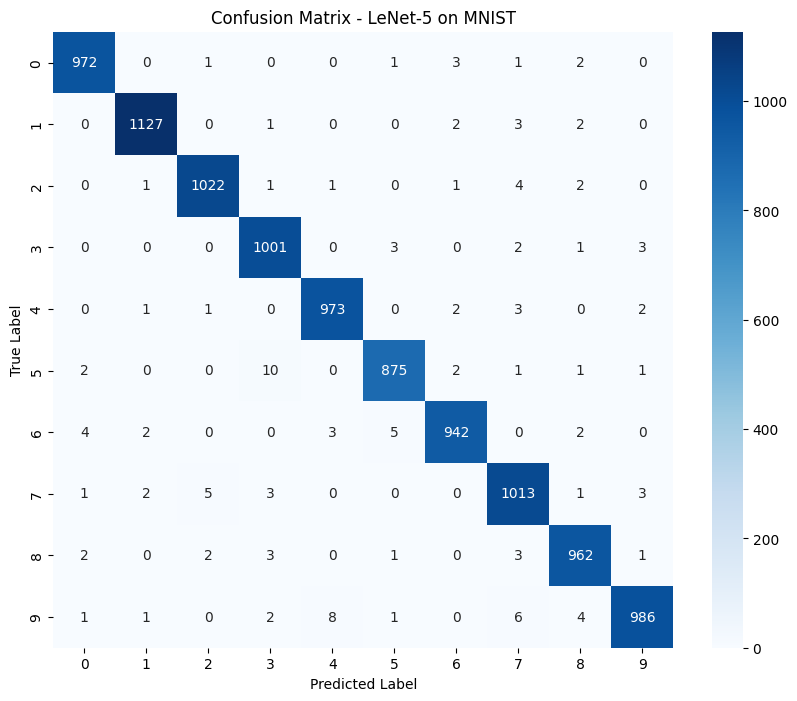

In [10]:
# ===================================================================
# 8. CONFUSION MATRIX VISUALIZATION
# ===================================================================

from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_test, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - LeNet-5 on MNIST')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [14]:
# ===================================================================
# 9. EXECUTION SUMMARY
# ===================================================================

print("\n" + "="*80)
print("EXECUTION SUMMARY - LENET-5 HANDWRITING RECOGNITION")
print("="*80)

print(f" FINAL PERFORMANCE METRICS:")
print(f"   • Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   • Test Loss: {test_loss:.4f}")
print(f"   • Total Parameters: {lenet_model.count_params():,}")

print(f"\n TRAINING CONFIGURATION:")
print(f"   • Architecture: LeNet-5 (Classic CNN)")
print(f"   • Epochs: 20")
print(f"   • Batch Size: 128")
print(f"   • Optimizer: Adam")
print(f"   • Loss Function: Categorical Crossentropy")

print(f"\n TRAINING RESULTS:")
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"   • Final Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   • Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")

# Check for overfitting
if final_train_acc - final_val_acc > 0.05:
    print(f"   • Note: Model shows signs of overfitting")
else:
    print(f"   • Note: Model shows good generalization")

print(f"\n CONCLUSION:")
if test_accuracy > 0.98:
    print(f"   Excellent performance! LeNet-5 achieved >98% accuracy on MNIST.")
elif test_accuracy > 0.95:
    print(f"   Very good performance! LeNet-5 achieved >95% accuracy on MNIST.")
elif test_accuracy > 0.90:
    print(f"   Good performance! LeNet-5 achieved >90% accuracy on MNIST.")
else:
    print(f"   Reasonable performance for this classic architecture.")

print(f"\n The LeNet-5 model successfully demonstrates the effectiveness of")
print(f"   Convolutional Neural Networks for handwritten digit recognition,")
print(f"   achieving {test_accuracy*100:.1f}% accuracy on the MNIST test set.")
print("="*80)


EXECUTION SUMMARY - LENET-5 HANDWRITING RECOGNITION
 FINAL PERFORMANCE METRICS:
   • Test Accuracy: 0.9873 (98.73%)
   • Test Loss: 0.0395
   • Total Parameters: 61,706

 TRAINING CONFIGURATION:
   • Architecture: LeNet-5 (Classic CNN)
   • Epochs: 20
   • Batch Size: 128
   • Optimizer: Adam
   • Loss Function: Categorical Crossentropy

 TRAINING RESULTS:
   • Final Training Accuracy: 0.9998 (99.98%)
   • Final Validation Accuracy: 0.9873 (98.73%)
   • Note: Model shows good generalization

 CONCLUSION:
   Excellent performance! LeNet-5 achieved >98% accuracy on MNIST.

 The LeNet-5 model successfully demonstrates the effectiveness of
   Convolutional Neural Networks for handwritten digit recognition,
   achieving 98.7% accuracy on the MNIST test set.
